
Setup


In [1]:
import os
import sys
import matplotlib.pyplot as plt


# Upgrade pip, just in case...
!{sys.executable} -m pip install --upgrade -q pip

     |████████████████████████████████| 2.1 MB 5.0 MB/s 


In [2]:
# Install requests for downloading data.
!{sys.executable} -m pip install --upgrade -q requests
!{sys.executable} -m pip install --upgrade -q pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 16.2 MB/s eta 0:00:00


In [3]:
#Import Dependencies

from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

## COVID Dataset

TCIA Basics

In [4]:
import requests

tcia_utils_text = requests.get("https://github.com/kirbyju/TCIA_Notebooks/raw/main/tcia_utils.py")
with open('tcia_utils.py', 'wb') as f:
    f.write(tcia_utils_text.content)

In [5]:
import tcia_utils as tcia

In [6]:
# Download a "Shared Cart" that has been previously 
#    created via the NBIA webset 
#    (https://nbia.cancerimagingarchive.net)
# cartName = "nbia-77761668716072016" # Their example shared cart
# cartName = "nbia-47881669847357616" # Our lung cancer data's first subject
# cartName = "nbia-95651669947463238" # Cart with both cancer and covid data
cartName = "nbia-6761669942417940" # Cart with covid data

# retrieve cart metadata
cart_data = tcia.getSharedCart(cartName)

# download the series_uids list and return dataframe of metadata
df = tcia.downloadSeries(cart_data)

# display dataframe
display(df)

Calling...  https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName?name=nbia-6761669942417940
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.99.1071.14850676509103506699400577275960
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.99.1071.21083349907841416087078944245719
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.99.1071.22090542070462647745743105373525
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.99.1071.22366983673254100505145504004129
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class UID,Number of Images,File Size,Series Number,License Name,License URL,Annotation Size
0,1.3.6.1.4.1.14519.5.2.1.99.1071.14850676509103...,COVID-19-NY-SBU,NO,https://doi.org/10.7937/TCIA.BBAG-2923,A034518,1.3.6.1.4.1.14519.5.2.1.99.1071.28052166218470...,CT ABD PELVISWITH CHEST IMAGES W IV CON,12-31-1900,2.0,TOSHIBA,CT,1.2.840.10008.5.1.4.1.1.2,2,1314900,1.000000,Creative Commons Attribution 4.0 International...,https://creativecommons.org/licenses/by/4.0/,0
1,1.3.6.1.4.1.14519.5.2.1.99.1071.21083349907841...,COVID-19-NY-SBU,NO,https://doi.org/10.7937/TCIA.BBAG-2923,A034518,1.3.6.1.4.1.14519.5.2.1.99.1071.28052166218470...,CT ABD PELVISWITH CHEST IMAGES W IV CON,12-31-1900,Body 3.000 CE,TOSHIBA,CT,1.2.840.10008.5.1.4.1.1.2,118,160721790,7.000000,Creative Commons Attribution 4.0 International...,https://creativecommons.org/licenses/by/4.0/,0
2,1.3.6.1.4.1.14519.5.2.1.99.1071.22090542070462...,COVID-19-NY-SBU,NO,https://doi.org/10.7937/TCIA.BBAG-2923,A034518,1.3.6.1.4.1.14519.5.2.1.99.1071.28052166218470...,CT ABD PELVISWITH CHEST IMAGES W IV CON,12-31-1900,Body 3.000 CE,TOSHIBA,CT,1.2.840.10008.5.1.4.1.1.2,89,121222124,6.000000,Creative Commons Attribution 4.0 International...,https://creativecommons.org/licenses/by/4.0/,0
3,1.3.6.1.4.1.14519.5.2.1.99.1071.22366983673254...,COVID-19-NY-SBU,NO,https://doi.org/10.7937/TCIA.BBAG-2923,A034518,1.3.6.1.4.1.14519.5.2.1.99.1071.28052166218470...,CT ABD PELVISWITH CHEST IMAGES W IV CON,12-31-1900,Lung 1.0 CE,TOSHIBA,CT,1.2.840.10008.5.1.4.1.1.2,596,314916466,4.000000,Creative Commons Attribution 4.0 International...,https://creativecommons.org/licenses/by/4.0/,0
4,1.3.6.1.4.1.14519.5.2.1.99.1071.30475546417294...,COVID-19-NY-SBU,NO,https://doi.org/10.7937/TCIA.BBAG-2923,A034518,1.3.6.1.4.1.14519.5.2.1.99.1071.28052166218470...,CT ABD PELVISWITH CHEST IMAGES W IV CON,12-31-1900,Body 5.0 CE,TOSHIBA,CT,1.2.840.10008.5.1.4.1.1.2,120,63405602,2.000000,Creative Commons Attribution 4.0 International...,https://creativecommons.org/licenses/by/4.0/,0
5,1.3.6.1.4.1.14519.5.2.1.99.1071.85179820664090...,COVID-19-NY-SBU,NO,https://doi.org/10.7937/TCIA.BBAG-2923,A034518,1.3.6.1.4.1.14519.5.2.1.99.1071.28052166218470...,CT ABD PELVISWITH CHEST IMAGES W IV CON,12-31-1900,Lung 5.0 CE,TOSHIBA,CT,1.2.840.10008.5.1.4.1.1.2,120,63405842,3.000000,Creative Commons Attribution 4.0 International...,https://creativecommons.org/licenses/by/4.0/,0


In [7]:
# For this demo...

# Install itk for DICOM I/O and for reading DICOM into an itkImage 
#   that manages all DICOM field values, include acquistion details 
#   such as voxel image, image orientation, and image directions
#   which are critical to image processing and display
!{sys.executable} -m pip install --upgrade --pre -q "itk==5.3rc4.post3"

# Additionally we'll install numpy and torch to explore a variety of 
#    image data structures
!{sys.executable} -m pip install -q torch
!{sys.executable} -m pip install -q numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 MB 11.8 MB/s eta 0:00:00


In [8]:
# Include ITK for DICOM reading
import itk

# Numpy for numpy.arrays
import numpy as np

# Torch for torch.tensors
import torch

In [9]:
# Install and import PyDICOM, then store file paths in list

!{sys.executable} -m pip install pydicom

import pydicom as di 
import os
from os import listdir
os.rename("tciaDownload", "tciaDownloadCOVID")
PathDicom = "tciaDownloadCOVID"
CovidDCMFiles = [] 
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():
            CovidDCMFiles.append(os.path.join(dirName,filename))
print("Number of (.dcm) files =", len(CovidDCMFiles))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.1 MB/s eta 0:00:00
Number of (.dcm) files = 1045


In [10]:
ds=di.dcmread(CovidDCMFiles[0])
print(ds)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.99.1071.15771526784735199076362870087131
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.99.1071.1577152

In [11]:
# Extract pixel data from image files

X_covid = []
y_covid = []
for k in CovidDCMFiles:
    Images = di.read_file(k,force=True)
    if Images.pixel_array.shape == (512,512):
      monochrome_data = Images.pixel_array
      monochrome_data = cv2.resize(monochrome_data, (224, 224))
      rgb_data = np.stack([monochrome_data, monochrome_data, monochrome_data])
      rgb_data = rgb_data.transpose((1,2,0))
      X_covid.append(rgb_data)
      y_covid.append(0) # 0 = covid data, 1 = cancer data    

In [12]:
X_covid

[array([[[-2048, -2048, -2048],
         [-2048, -2048, -2048],
         [-2048, -2048, -2048],
         ...,
         [-2048, -2048, -2048],
         [-2048, -2048, -2048],
         [-2048, -2048, -2048]],
 
        [[-2048, -2048, -2048],
         [-2048, -2048, -2048],
         [-2048, -2048, -2048],
         ...,
         [-2048, -2048, -2048],
         [-2048, -2048, -2048],
         [-2048, -2048, -2048]],
 
        [[-2048, -2048, -2048],
         [-2048, -2048, -2048],
         [-2048, -2048, -2048],
         ...,
         [-2048, -2048, -2048],
         [-2048, -2048, -2048],
         [-2048, -2048, -2048]],
 
        ...,
 
        [[-2048, -2048, -2048],
         [-2048, -2048, -2048],
         [-2048, -2048, -2048],
         ...,
         [-2048, -2048, -2048],
         [-2048, -2048, -2048],
         [-2048, -2048, -2048]],
 
        [[-2048, -2048, -2048],
         [-2048, -2048, -2048],
         [-2048, -2048, -2048],
         ...,
         [-2048, -2048, -2048],
       

In [13]:
X_covid[0]


array([[[-2048, -2048, -2048],
        [-2048, -2048, -2048],
        [-2048, -2048, -2048],
        ...,
        [-2048, -2048, -2048],
        [-2048, -2048, -2048],
        [-2048, -2048, -2048]],

       [[-2048, -2048, -2048],
        [-2048, -2048, -2048],
        [-2048, -2048, -2048],
        ...,
        [-2048, -2048, -2048],
        [-2048, -2048, -2048],
        [-2048, -2048, -2048]],

       [[-2048, -2048, -2048],
        [-2048, -2048, -2048],
        [-2048, -2048, -2048],
        ...,
        [-2048, -2048, -2048],
        [-2048, -2048, -2048],
        [-2048, -2048, -2048]],

       ...,

       [[-2048, -2048, -2048],
        [-2048, -2048, -2048],
        [-2048, -2048, -2048],
        ...,
        [-2048, -2048, -2048],
        [-2048, -2048, -2048],
        [-2048, -2048, -2048]],

       [[-2048, -2048, -2048],
        [-2048, -2048, -2048],
        [-2048, -2048, -2048],
        ...,
        [-2048, -2048, -2048],
        [-2048, -2048, -2048],
        [-2048,

In [14]:
X_covid[0].shape

(224, 224, 3)

In [15]:
X_covid_array = np.array(X_covid)
print(X_covid_array.ndim)

4


In [16]:
X_covid_array.shape

(836, 224, 224, 3)

In [17]:
X_covid_1darray = X_covid_array.reshape(-1)
X_covid_1darray.shape

(125841408,)

In [18]:
# Use the data frame to find the Series UID where the Modality is CT
dicom_data_dir = "tciaDownloadCOVID/"
ct_series_uid = df.at[df.Modality.eq('CT').idxmax(), 'Series UID']
dicom_ct_dir = os.path.join(dicom_data_dir, ct_series_uid)


# Load and sort the DICOM data into a volume - since no series_uid is
#    specified with this read command, it will load the first series in the directory.
dicom_image_large = itk.imread(dicom_ct_dir, itk.F)

# To save time for this demo, we subsample the image in the x and y dimensions
new_spacing = list(dicom_image_large.GetSpacing())
new_spacing[:2] = [x*3 for x in new_spacing[:2]]
new_size = list(dicom_image_large.GetLargestPossibleRegion().GetSize())
new_size[:2] = [x//3 for x in new_size[:2]]
dicom_image = itk.resample_image_filter(Input=dicom_image_large,
                                        output_spacing=new_spacing, 
                                        output_origin=dicom_image_large.GetOrigin(), 
                                        output_direction=dicom_image_large.GetDirection(),
                                        size=new_size)
print(f"New spacing = {new_spacing}")
print(f"New size = {new_size}")

OSError: ignored

## Cancer Dataset

In [19]:
# Download a "Shared Cart" that has been previously 
#    created via the NBIA webset 
#    (https://nbia.cancerimagingarchive.net)
# cartName = "nbia-77761668716072016" # Their example shared cart
cartName = "nbia-47881669847357616" # Our lung cancer data's first subject
# cartName = "nbia-95651669947463238" # Cart with both cancer and covid data

# retrieve cart metadata
cart_data = tcia.getSharedCart(cartName)

# download the series_uids list and return dataframe of metadata
df = tcia.downloadSeries(cart_data)

# display dataframe
display(df)

Calling...  https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName?name=nbia-47881669847357616
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.6655.2359.213534032021332276911485641315
Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.6655.2359.257508444832901632590301540805
Download Complete: 2 Series Instance UIDs (scans).


,Series UID,Collection,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class UID,Number of Images,File Size,Series Number,License Name,License URL,Annotation Size
0,1.3.6.1.4.1.14519.5.2.1.6655.2359.213534032021...,Lung-PET-CT-Dx,https://doi.org/10.7937/TCIA.2020.NNC2-0461,Lung_Dx-A0001,1.3.6.1.4.1.14519.5.2.1.6655.2359.165554066086...,Chest,04-04-2007,5mm,Philips,CT,1.2.840.10008.5.1.4.1.1.2,64,33750912,3.000000,Creative Commons Attribution 4.0 International...,https://creativecommons.org/licenses/by/4.0/,0
1,1.3.6.1.4.1.14519.5.2.1.6655.2359.257508444832...,Lung-PET-CT-Dx,https://doi.org/10.7937/TCIA.2020.NNC2-0461,Lung_Dx-A0001,1.3.6.1.4.1.14519.5.2.1.6655.2359.165554066086...,Chest,04-04-2007,5mm,Philips,CT,1.2.840.10008.5.1.4.1.1.2,64,33750912,2.000000,Creative Commons Attribution 4.0 International...,https://creativecommons.org/licenses/by/4.0/,0


In [20]:
os.rename("tciaDownload", "tciaDownloadCancer")
PathDicom = "tciaDownloadCancer"
CancerDCMFiles = [] 
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():
            CancerDCMFiles.append(os.path.join(dirName,filename))
print("Number of (.dcm) files =", len(CancerDCMFiles))

Number of (.dcm) files = 128


In [21]:
# Extract pixel data from image files

X_cancer = []
y_cancer = []
for k in CancerDCMFiles:
    Images = di.read_file(k,force=True)
    if Images.pixel_array.shape == (512,512):
      monochrome_data = Images.pixel_array
      monochrome_data = cv2.resize(monochrome_data, (224, 224))
      rgb_data = np.stack([monochrome_data, monochrome_data, monochrome_data])
      rgb_data = rgb_data.transpose((1,2,0))
      X_cancer.append(rgb_data)
      y_cancer.append(1) # 0 = covid data, 1 = cancer data

In [22]:
X_cancer

[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint16), array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 

In [23]:
type(X_cancer)

list

In [24]:
len(X_cancer)

128

In [25]:
type(X_cancer[0])

numpy.ndarray

In [26]:
X_cancer[0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint16)

In [27]:
for n in X_cancer:
  print(n.shape)     

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 

In [28]:
X_cancer_array = np.array(X_cancer)
print(X_cancer_array.ndim)

4


In [29]:
X_cancer_array.shape

(128, 224, 224, 3)

In [30]:
# Use the data frame to find the Series UID where the Modality is CT
dicom_data_dir = "tciaDownloadCancer/"
ct_series_uid = df.at[df.Modality.eq('CT').idxmax(), 'Series UID']
dicom_ct_dir = os.path.join(dicom_data_dir, ct_series_uid)

# Load and sort the DICOM data into a volume - since no series_uid is
#    specified with this read command, it will load the first series in the directory.
dicom_image_large = itk.imread(dicom_ct_dir, itk.F)

# To save time for this demo, we subsample the image in the x and y dimensions
new_spacing = list(dicom_image_large.GetSpacing())
new_spacing[:2] = [x*3 for x in new_spacing[:2]]
new_size = list(dicom_image_large.GetLargestPossibleRegion().GetSize())
new_size[:2] = [x//3 for x in new_size[:2]]
dicom_image = itk.resample_image_filter(Input=dicom_image_large,
                                        output_spacing=new_spacing, 
                                        output_origin=dicom_image_large.GetOrigin(), 
                                        output_direction=dicom_image_large.GetDirection(),
                                        size=new_size)
print(f"New spacing = {new_spacing}")
print(f"New size = {new_size}")

New spacing = [2.525390625, 2.525390625, 5.0]
New size = [170, 170, 64]


# Train Test Split 

In [31]:
# Convert to array 
X_covid = np.array(X_covid) 
X_cancer = np.array(X_cancer)

print(X_covid.ndim)
print(X_cancer.ndim)

# Split into training and testing sets for both types of images
X_covid_train, X_covid_test, y_covid_train, y_covid_test = train_test_split(
    X_covid, y_covid, test_size=0.2)
X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = train_test_split(
    X_cancer, y_cancer, test_size=0.2)



4
4


In [32]:
X_covid.shape


(836, 224, 224, 3)

In [33]:
X_cancer.shape


(128, 224, 224, 3)

In [34]:
# Merge sets for both types of images
X_train = np.concatenate((X_covid_train, X_cancer_train), axis=0)
X_test = np.concatenate((X_covid_test, X_cancer_test), axis=0)
y_train = np.concatenate((y_covid_train, y_cancer_train), axis=0)
y_test = np.concatenate((y_covid_test, y_cancer_test), axis=0)


In [35]:
# Make labels into categories - either 0 or 1, for our model
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

# Building and Visualizing Model

In [45]:
# Building Model
resnet = ResNet50(weights="imagenet")

resnet.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)



102967424/102967424 [==============================] - 1s 0us/step


In [46]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

### Making Predictions

In [47]:
pred = resnet.predict(X_train)

25/25 [==============================] - 128s 5s/step


In [48]:
print('Predicted:', decode_predictions(pred, top=3))

35363/35363 [==============================] - 0s 0us/step
Predicted: [[('n03970156', 'plunger', 0.9999978), ('n03657121', 'lens_cap', 1.703399e-06), ('n03347037', 'fire_screen', 2.706791e-07)], [('n03970156', 'plunger', 0.9999959), ('n03657121', 'lens_cap', 1.6910556e-06), ('n03347037', 'fire_screen', 1.3998608e-06)], [('n03970156', 'plunger', 0.99999934), ('n03657121', 'lens_cap', 5.1857756e-07), ('n03691459', 'loudspeaker', 8.453993e-08)], [('n03970156', 'plunger', 0.99999887), ('n03347037', 'fire_screen', 7.755956e-07), ('n03657121', 'lens_cap', 2.0965369e-07)], [('n03970156', 'plunger', 0.99999756), ('n03347037', 'fire_screen', 1.8679078e-06), ('n03657121', 'lens_cap', 5.2991527e-07)], [('n03970156', 'plunger', 0.9999997), ('n03657121', 'lens_cap', 1.6105778e-07), ('n03691459', 'loudspeaker', 4.1926054e-08)], [('n03970156', 'plunger', 0.9999953), ('n03347037', 'fire_screen', 4.3474815e-06), ('n03691459', 'loudspeaker', 1.1227908e-07)], [('n03970156', 'plunger', 0.9999998), ('n0365

### Training the Model

In [55]:
outputs = resnet.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

trained_model = Model(inputs=resnet.input, outputs=outputs)



In [56]:
for layer in resnet.layers:
    layer.trainable = False

trained_model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

In [57]:
trained_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [58]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [65]:
# training config:
epochs = 5
batch_size = 32

In [66]:
history = trained_model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)


Epoch 1/5
24/24 [==============================] - 172s 7s/step - loss: 0.4222 - accuracy: 0.9260 - val_loss: 0.4089 - val_accuracy: 0.8660
Epoch 2/5
24/24 [==============================] - 162s 7s/step - loss: 0.3997 - accuracy: 0.9455 - val_loss: 0.3934 - val_accuracy: 0.8660
Epoch 3/5
24/24 [==============================] - 167s 7s/step - loss: 0.3932 - accuracy: 0.9208 - val_loss: 0.3795 - val_accuracy: 0.8660
Epoch 4/5
24/24 [==============================] - 168s 7s/step - loss: 0.3717 - accuracy: 0.9429 - val_loss: 0.3669 - val_accuracy: 0.8660
Epoch 5/5
24/24 [==============================] - 168s 7s/step - loss: 0.3743 - accuracy: 0.9247 - val_loss: 0.3547 - val_accuracy: 0.8660


In [67]:
# Save Model and Weights
trained_model.save('resnet_ct.h5')
trained_model.save_weights('resnet_weights_ct.hdf5')

In [68]:
# Load saved model
model = load_model('resnet_ct.h5')

## Making Predictions

In [69]:
y_pred = model.predict(X_test, batch_size=batch_size)

7/7 [==============================] - 41s 6s/step


In [70]:
print(y_pred)

[[0.75523156 0.24476835]
 [0.7494793  0.2505207 ]
 [0.7530127  0.24698724]
 [0.7512611  0.24873878]
 [0.7625731  0.23742682]
 [0.74972755 0.2502725 ]
 [0.7494713  0.2505286 ]
 [0.7593143  0.2406857 ]
 [0.7599936  0.24000636]
 [0.762178   0.23782197]
 [0.7494777  0.25052238]
 [0.76238054 0.23761944]
 [0.76259816 0.23740198]
 [0.7543993  0.24560069]
 [0.74950343 0.25049657]
 [0.74947345 0.25052646]
 [0.75247097 0.24752904]
 [0.7620957  0.23790437]
 [0.7540425  0.24595743]
 [0.74962056 0.2503795 ]
 [0.7516315  0.24836855]
 [0.7536826  0.24631749]
 [0.7496238  0.25037622]
 [0.7495646  0.25043547]
 [0.7557336  0.24426638]
 [0.7555698  0.2444302 ]
 [0.749555   0.25044498]
 [0.7558995  0.24410048]
 [0.7551307  0.24486928]
 [0.7503673  0.24963278]
 [0.7494708  0.2505291 ]
 [0.75896233 0.24103756]
 [0.7524936  0.24750644]
 [0.7629483  0.23705171]
 [0.761333   0.2386669 ]
 [0.7591374  0.24086255]
 [0.7524129  0.24758697]
 [0.76064116 0.2393588 ]
 [0.76262915 0.23737086]
 [0.7628867  0.23711327]


In [76]:
len(y_pred)

194

### Visualizing Predictions

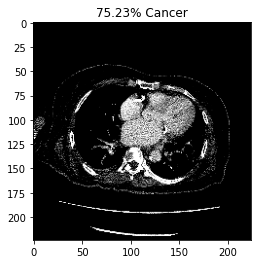

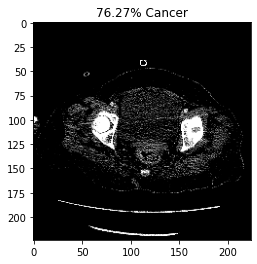

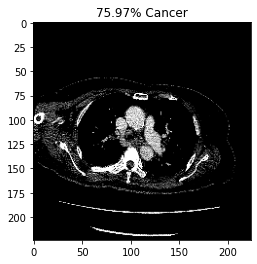

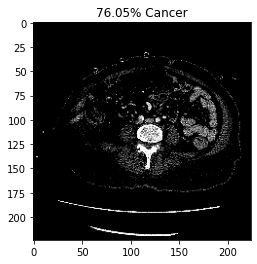

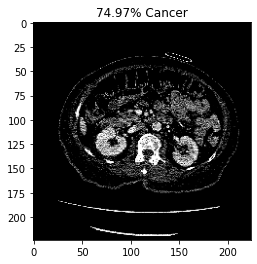

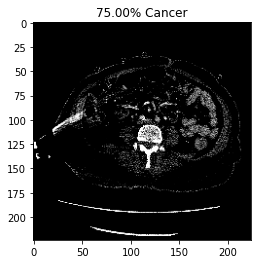

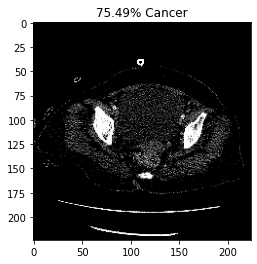

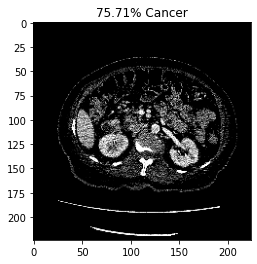

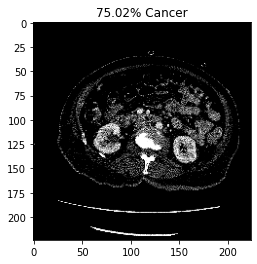

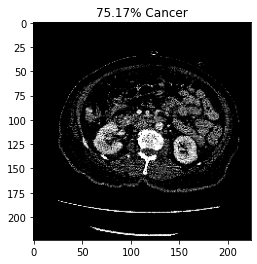

In [81]:
prediction=y_pred[115:125]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% Cancer')
  plt.imshow(X_test[index])
  plt.show()

In [80]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

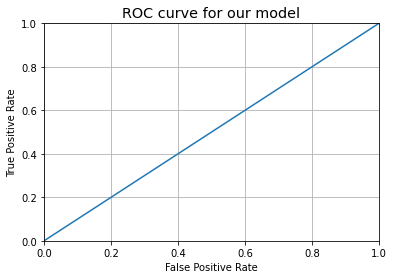

In [82]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)